In [1]:
import typing as tp
import pandas as pd
import numpy as np
import random
import pickle
import torch

from tqdm import tqdm
from pathlib import Path
#from common import * # this line comes from WildMe, not sure which common library this is referring to

### Load precomputed list of matches

We have generated a match list on the MiewID Beluga test dataset and stored it at ```/srv/transparency/wildbook_prototype/data/matches```.

In [2]:
def unpickler(fp: Path | str):
    if isinstance(fp, str):
        fp = Path(fp)

    try:
        with open(fp, "r") as f:
            return pickle.load(f)
    except UnicodeDecodeError:
        with open(fp, "rb") as f:
            return pickle.load(f)

match_path = '/srv/transparency/wildbook_prototype/data/matches'
print([p for p in Path(match_path).glob("*")])

### df_test stores the dataframe containing metadata for the N instances of the test dataset
df_test = unpickler(Path(match_path, "df_test.pkl"))

### test_dataset stores the actual MiewIDDataset object used during evaluation
test_dataset = unpickler(Path(match_path, "test_dataset.pkl"))

### match_results stores 4 tensors:
###     match_results[0] := (N)-dimensional array of true PID
###     match_results[1] := (N,k)-dimensional tensor of top-k index guesses. Each row is the top-k indices *in the match matrix* for a single instance.
###     match_results[2] := (N,k)-dimensional tensor of top-k true PIDs. Each row is the top-k guesses for a single instance.
###     match_results[3] := (N,k)-dimensional tensor of the match matrix indicating success/failure of the top-k guesses
match_results = unpickler(Path(match_path, "match_results.pkl"))
q_pids = unpickler(Path(match_path, "q_pids.pkl")) # identical to match_results[0]
topk_idx = unpickler(Path(match_path, "topk_idx.pkl")) # identical to match_results[1]
topk_names = unpickler(Path(match_path, "topk_names.pkl")) # identical to match_results[2]
match_mat = unpickler(Path(match_path, "match_mat.pkl")) # identical to match_results[3]

### distmat stores the (N,N)-dimensional pairwise distance matrix between the embeddings for all N instances in the test set
distmat = unpickler(Path(match_path, "distmat.pkl"))

# Iterate throught test dataset
print("Loading images from test set")
data_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
            num_workers=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
)
batched_images = []
tk0 = tqdm(data_loader, total=len(data_loader))
with torch.no_grad():
    for batch in tk0:
        batched_images.append(batch["image"])

# Combine images into a single tensor
images = torch.stack(batched_images).squeeze(dim=1)
print(f"Loaded images: {images.shape}")
del batched_images

[PosixPath('/srv/transparency/wildbook_prototype/data/matches/ranks.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/q_pids.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/match_results.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/test_dataset.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/df_test.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/topk_names.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/distmat.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/match_mat.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/topk_idx.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/example.ipynb')]
Loading images from test set


100%|██████████| 849/849 [00:09<00:00, 91.02it/s] 


Loaded images: torch.Size([849, 3, 440, 440])


In [3]:
df_test.head()

,Unnamed: 0.1,Unnamed: 0,theta,viewpoint,file_name,species,file_path,x,y,w,h,name,bbox,name_species,name_orig
0,2,2,0.0,up,000000005187.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,120,440,0,"[0, 0, 120, 440]",102_beluga_whale,102
1,8,8,0.0,up,000000000133.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,145,440,0,"[0, 0, 145, 440]",102_beluga_whale,102
2,4,4,0.0,up,000000003910.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,146,440,0,"[0, 0, 146, 440]",102_beluga_whale,102
3,9,9,0.0,up,000000005189.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,135,440,0,"[0, 0, 135, 440]",102_beluga_whale,102
4,1,1,0.0,up,000000005193.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,127,440,0,"[0, 0, 127, 440]",102_beluga_whale,102


In [ ]:
import mpatlotlib 

plot(images)

### LightGlue benchmarking

In [ ]:
### Install LightGlue if necessary
!git clone https://github.com/cvg/LightGlue.git && cd LightGlue && pip install -e .

In [3]:
import lightglue
from lightglue import LightGlue, SuperPoint, DISK, viz2d
from lightglue.utils import rbd
from torchvision import transforms

def _lightglue(image0: torch.Tensor, image1: torch.Tensor) -> dict:
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    return feats0, feats1, matches01

def _lightglue_vis(image0, image1, feats0, feats1, matches01):
    def unnormalize(img_base):
        aug_mean = np.array([0.485, 0.456, 0.406])
        aug_std = np.array([0.229, 0.224, 0.225])
        unnormalize = transforms.Normalize((-aug_mean / aug_std).tolist(), (1.0 / aug_std).tolist())
        img_unnorm = unnormalize(img_base)

        return img_unnorm
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    axes = viz2d.plot_images([unnormalize(image0), unnormalize(image1)])
    viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
    viz2d.plot_images([unnormalize(image0), unnormalize(image1)])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

### Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

### Load the SuperPoint extractor and put it on the GPU
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)

### Load the LightGlue matcher and put it on the GPU
matcher = LightGlue(features="superpoint").eval().to(device)

In [ ]:
# Benchmark LightGlue
%timeit -n 100 _lightglue(random.choice(images), random.choice(images))

In [ ]:
# Benchmark LightGlue visualization
image0 = random.choice(images)
image1 = random.choice(images)
feats0, feats1, matches01 = _lightglue(image0, image1)

In [ ]:
%timeit -n 2 _lightglue_vis(image0, image1, feats0, feats1, matches01)

  0%|          | 0/849 [00:01<?, ?it/s]


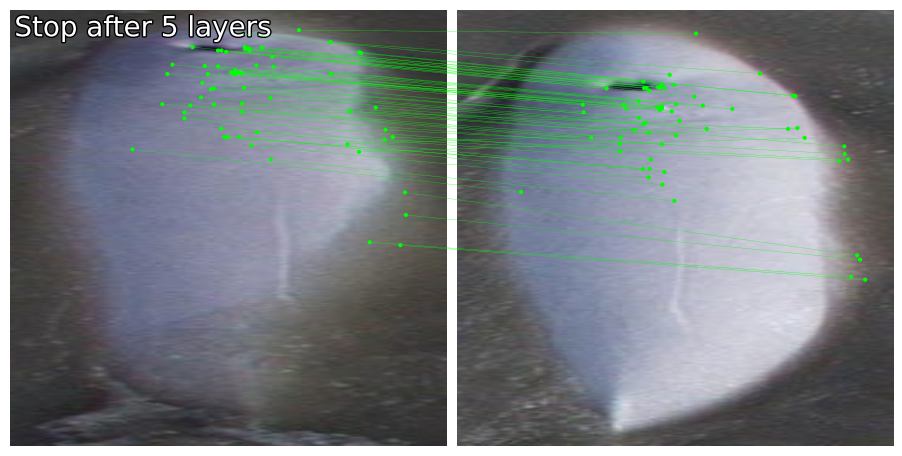

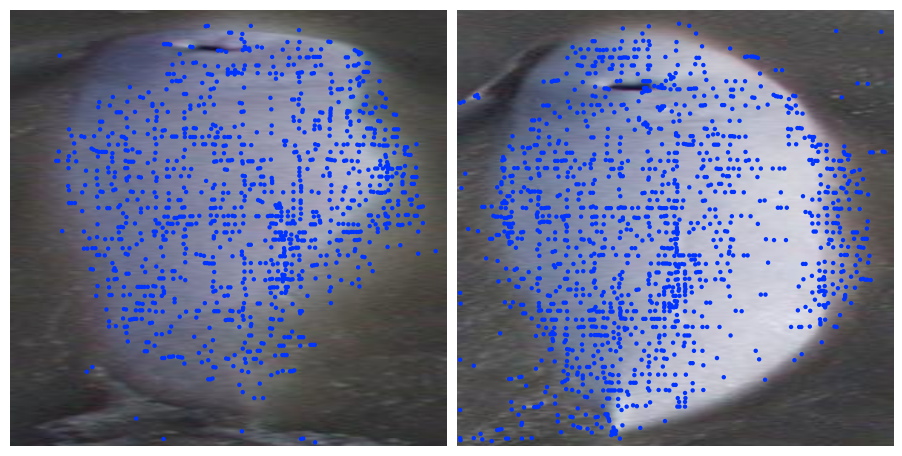

In [5]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        image1 = images[match]
        feats0, feats1, matches01 = _lightglue(image0, image1)
        _lightglue_vis(image0, image1, feats0, feats1, matches01)
        break
    break

### GradCam

In [ ]:
# INSERT GRADCAM INSTALLATION HERE #
#pip install ...

In [ ]:
# INSERT GRADCAM BOILERPLATE CODE HERE #
# imports

# helpers

# main functions
def _gradcam(*args):
    pass

def _vis_gradcam(*args):
    pass

In [ ]:
# BENCHMARK GRADCAM HERE #
#%timeit -n 100 _gradcam(random.choice(images), random.choice(images))

In [ ]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        image1 = images[match]
        # INSERT GRADCAM VISUALIZATION CODE HERE #
        break
    break